In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col=["year"])
df

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


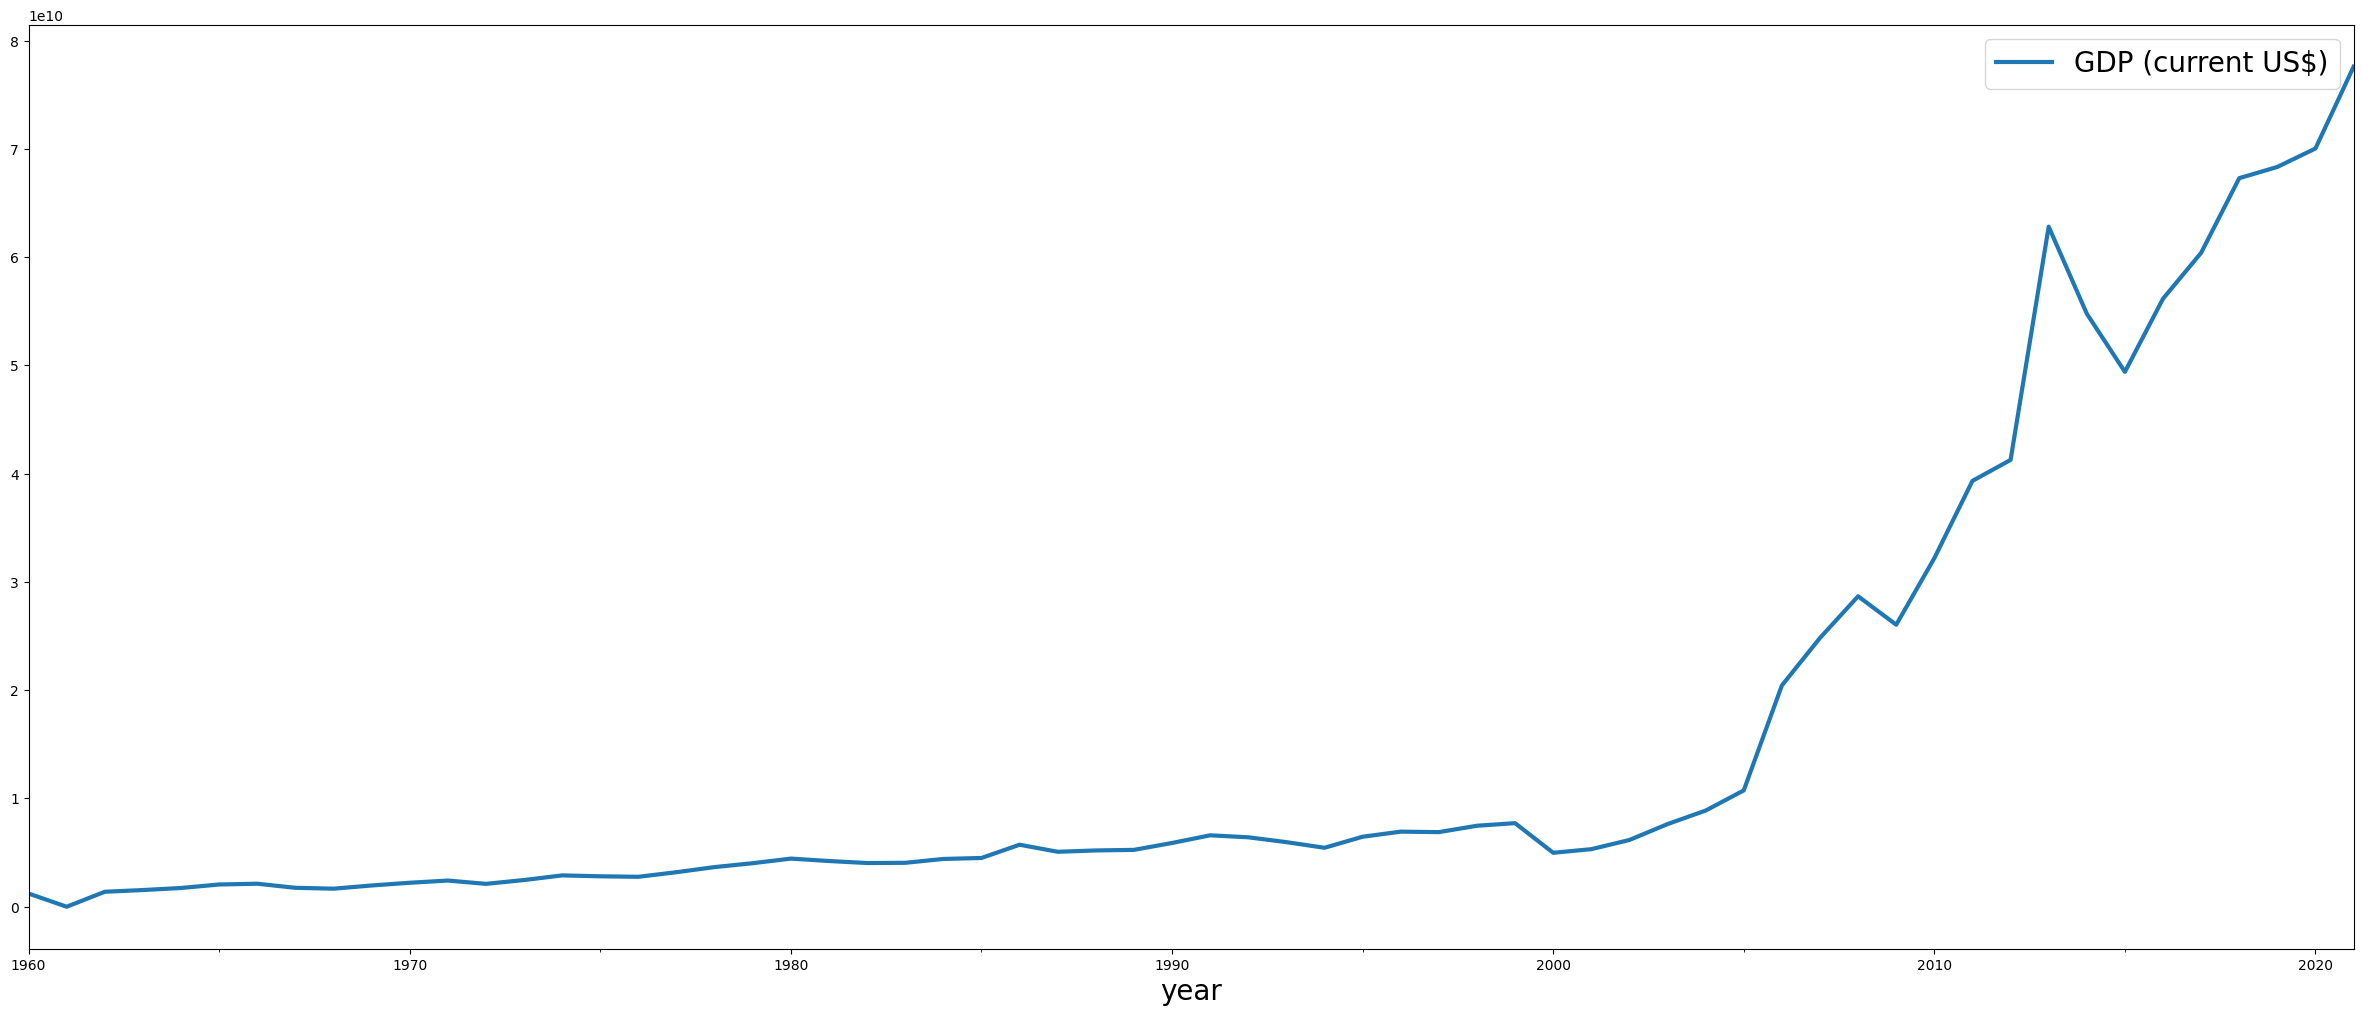

In [3]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

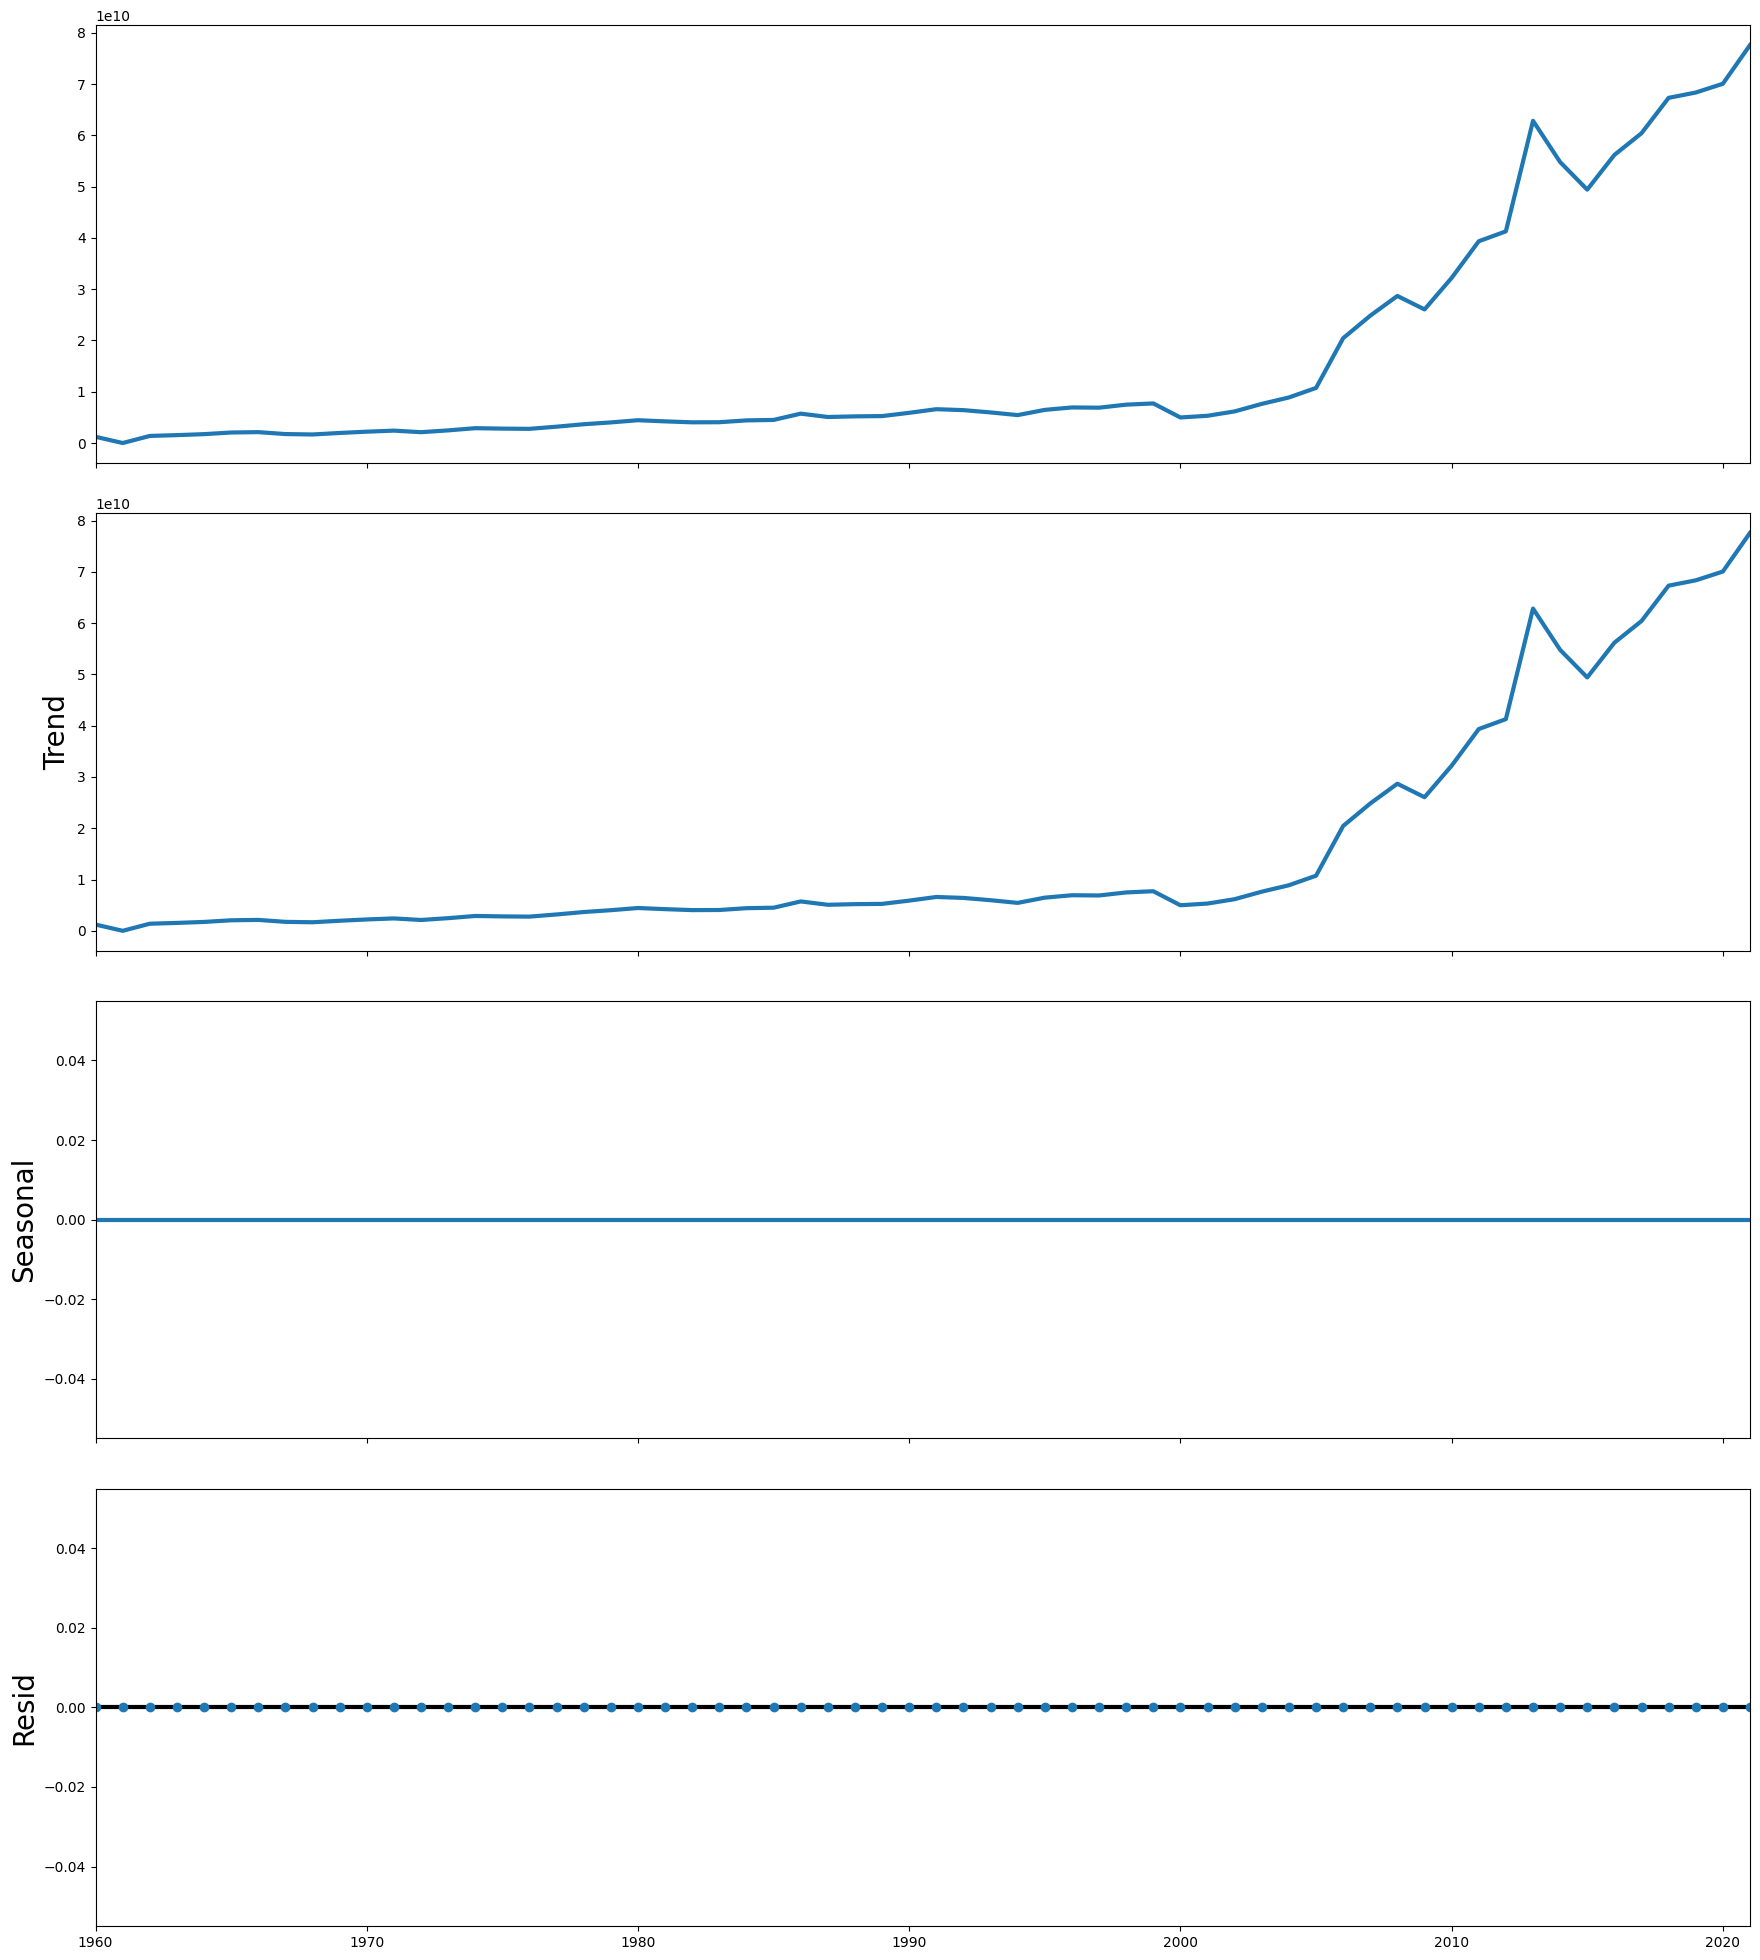

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(df)
result.plot()
plt.show()

В датасете представлены данные по ВВП Ганы с 1960 по 2020 год. В данных есть тренд, отсутствует сезонность. Отсутствие сезонности вполне логично, ВВП страны врядли может зависеть от каких-то временных рамок. Резкий рост ВВП в 2000-х годах связан с тем, что в Гане были обнаружены запасы нефти и началась их добыча. Шум также отсутствует, так как выборка небольшая и редкая.

In [5]:
train_df = df.loc[:"2019-01-01"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((60, 1), (3, 1))

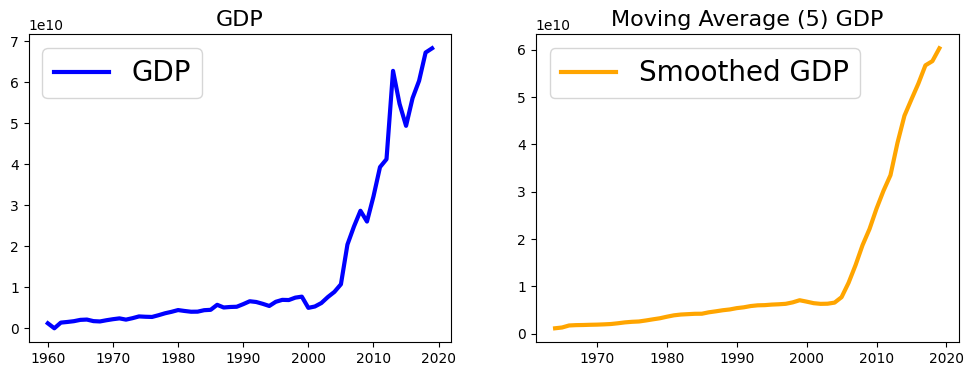

In [6]:
plt.rcParams["figure.figsize"] = 12, 4

fig, ax = plt.subplots(1, 2)

# Окно в месяц (Window = 30)
ax[0].plot(train_df, color="blue", label="GDP")
ax[0].set_title("GDP", size=16)
ax[0].legend()

ax[1].plot(
    train_df.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1].set_title("Moving Average (5) GDP", size=16)
ax[1].legend()

plt.show()

Скользящее среднее подтвердило наличие тренда в данных по ВВП Ганы.

In [7]:
from statsmodels.tsa.stattools import adfuller


In [8]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

In [9]:
test1 = stat_test(train_df["GDP (current US$)"])

adf:  0.5782902144237627
p-value:  0.9870681153049116
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть - ряд не является стационарным.

In [10]:
df_diff1 = train_df.diff().dropna()
test2 = stat_test(df_diff1["GDP (current US$)"])

adf:  -1.5585831471388782
p-value:  0.504358059567103
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


После дифференцирования ряда, ряд снова не является стационарным.

In [11]:
df_diff2 = df_diff1.diff().dropna()
test3 = stat_test(df_diff2["GDP (current US$)"])

adf:  -2.857721602753042
p-value:  0.05048992217549775
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


In [12]:
df_diff3 = df_diff2.diff().dropna()
test4 = stat_test(df_diff3["GDP (current US$)"])

adf:  -5.721917053004344
p-value:  6.909866550635754e-07
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


Произведено трехкратное дифференцирование, значение d=3.

In [13]:
import statsmodels.api as sm

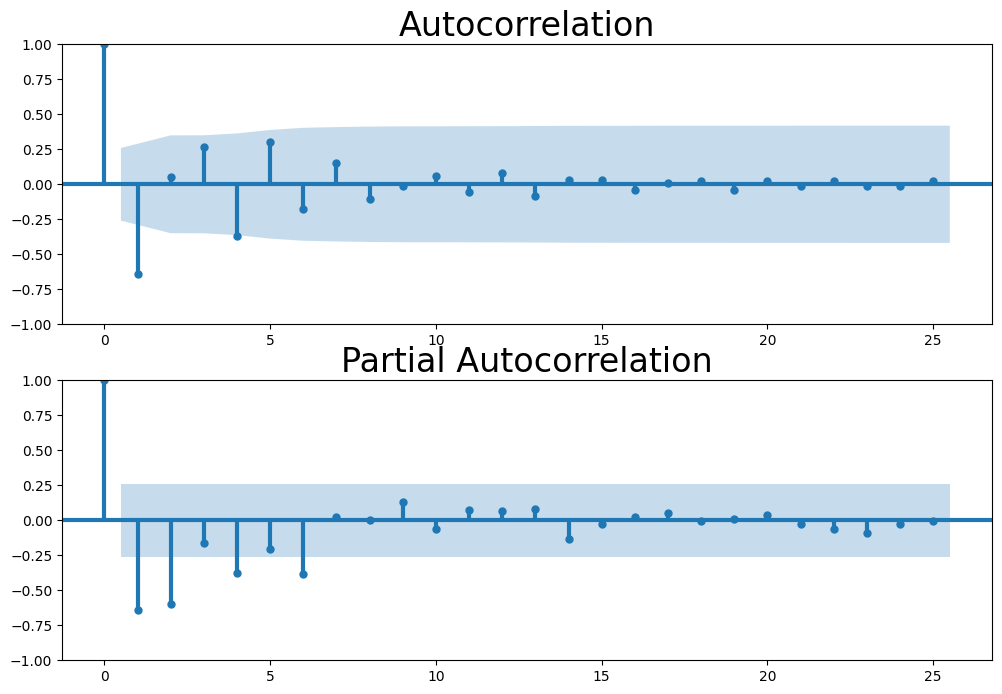

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff3.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff3, lags=25, ax=ax2)

Так как временной ряд не стационарен, учитывать экзогенные параметры не нужно, для предсказания построим ARIMA.

Построим модель **ARIMA** со следующими параметрами:

- p = 2 (определено по графику частичной автокорреляции)
- d = 3 (количество дифференцирований)
- q = 1 (определено по графику автокорреляции)


In [15]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   60
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1350.446
Date:                Sun, 20 Oct 2024   AIC                           2708.891
Time:                        15:11:19   BIC                           2717.064
Sample:                    01-01-1960   HQIC                          2712.067
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7473      0.138     -5.401      0.000      -1.019      -0.476
ar.L2         -0.4516      0.239     -1.893      0.058      -0.919       0.016
ma.L1         -0.9723      0.118     -8.269      0.000      -1.203      -0.742
sigma2      3.402e+19   5.96e-22   5.71e+40      0.000     3.4e+19     3.4e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):               142.38
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):             405.30   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.07e+56. Standard errors may be unstable.
"""

Параметр AIC, с помощью которого можно сравнивать качество моделей, равен 2708.891.

Для подбора оптимальных параметров используем pmdarima

In [16]:
# pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    d=3,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2718.190, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2783.546, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2754.958, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2730.057, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2708.891, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2730.545, Time=0.05 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2710.046, Time=0.19 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=2696.441, Time=0.11 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2711.248, Time=0.05 sec
 ARIMA(1,3,3)(0,0,0)[0]             : AIC=2714.134, Time=0.06 sec
 ARIMA(0,3,3)(0,0,0)[0]             : AIC=2735.960, Time=0.05 sec
 ARIMA(2,3,3)(0,0,0)[0]             : AIC=2702.979, Time=0.12 sec
 ARIMA(1,3,2)(0,0,0)[0] intercept   : AIC=2699.255, Time=0.14 sec

Best model:  ARIMA(1,3,2)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(1, 3, 2)   Log Likelihood               -1344.220
Date:                Sun, 20 Oct 2024   AIC                           2696.441
Time:                        15:11:28   BIC                           2704.613
Sample:                    01-01-1960   HQIC                          2699.617
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1764      0.170     -1.035      0.301      -0.510       0.158
ma.L1         -1.8566      0.235     -7.904      0.000      -2.317      -1.396
ma.L2          0.8710      0.267      3.258      0.001       0.347       1.395
sigma2      2.641e+19   3.35e-21   7.88e+39      0.000    2.64e+19    2.64e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               219.43
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):             433.48   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+56. Standard errors may be unstable.
"""

##### Для проверяющего ментора
К сожалению не удалось до конца понять как работает pmdarima. Какие бы начальные и конечные параметры p и q я не задавала, алгоритм не перебирает все вожможные варианты. По наблюдениям перебор идет только в диапазоне +2 от стартовых значений. Какой либо информации по этому поводу не в документации, не в поиске в интернете тоже я не нашла. Такой же вопрос задан менторам в Пачке, и там тоже нет на него ответа.

Предложенный pmdarima параметры показывают лучший критерий AIC, чем параметры, подобранные по графикам автокорреляции и частичной автокорреляции. Поэтому будем делать предсказания с помощью модели, обученной на параметрах, подобранных с помощью pmdarima.

In [18]:
arima_model2 = ARIMA(train_df["GDP (current US$)"].dropna(), order=(1, 3, 2))
arima_model2_fit = arima_model2.fit()
arima_model2_fit.summary()

c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   60
Model:                 ARIMA(1, 3, 2)   Log Likelihood               -1344.220
Date:                Sun, 20 Oct 2024   AIC                           2696.441
Time:                        15:11:28   BIC                           2704.613
Sample:                    01-01-1960   HQIC                          2699.617
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1764      0.170     -1.035      0.301      -0.510       0.158
ma.L1         -1.8566      0.235     -7.904      0.000      -2.317      -1.396
ma.L2          0.8710      0.267      3.258      0.001       0.347       1.395
sigma2      2.641e+19   3.35e-21   7.88e+39      0.000    2.64e+19    2.64e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               219.43
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):             433.48   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+56. Standard errors may be unstable.
"""

In [19]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model2_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model2_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05) 

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

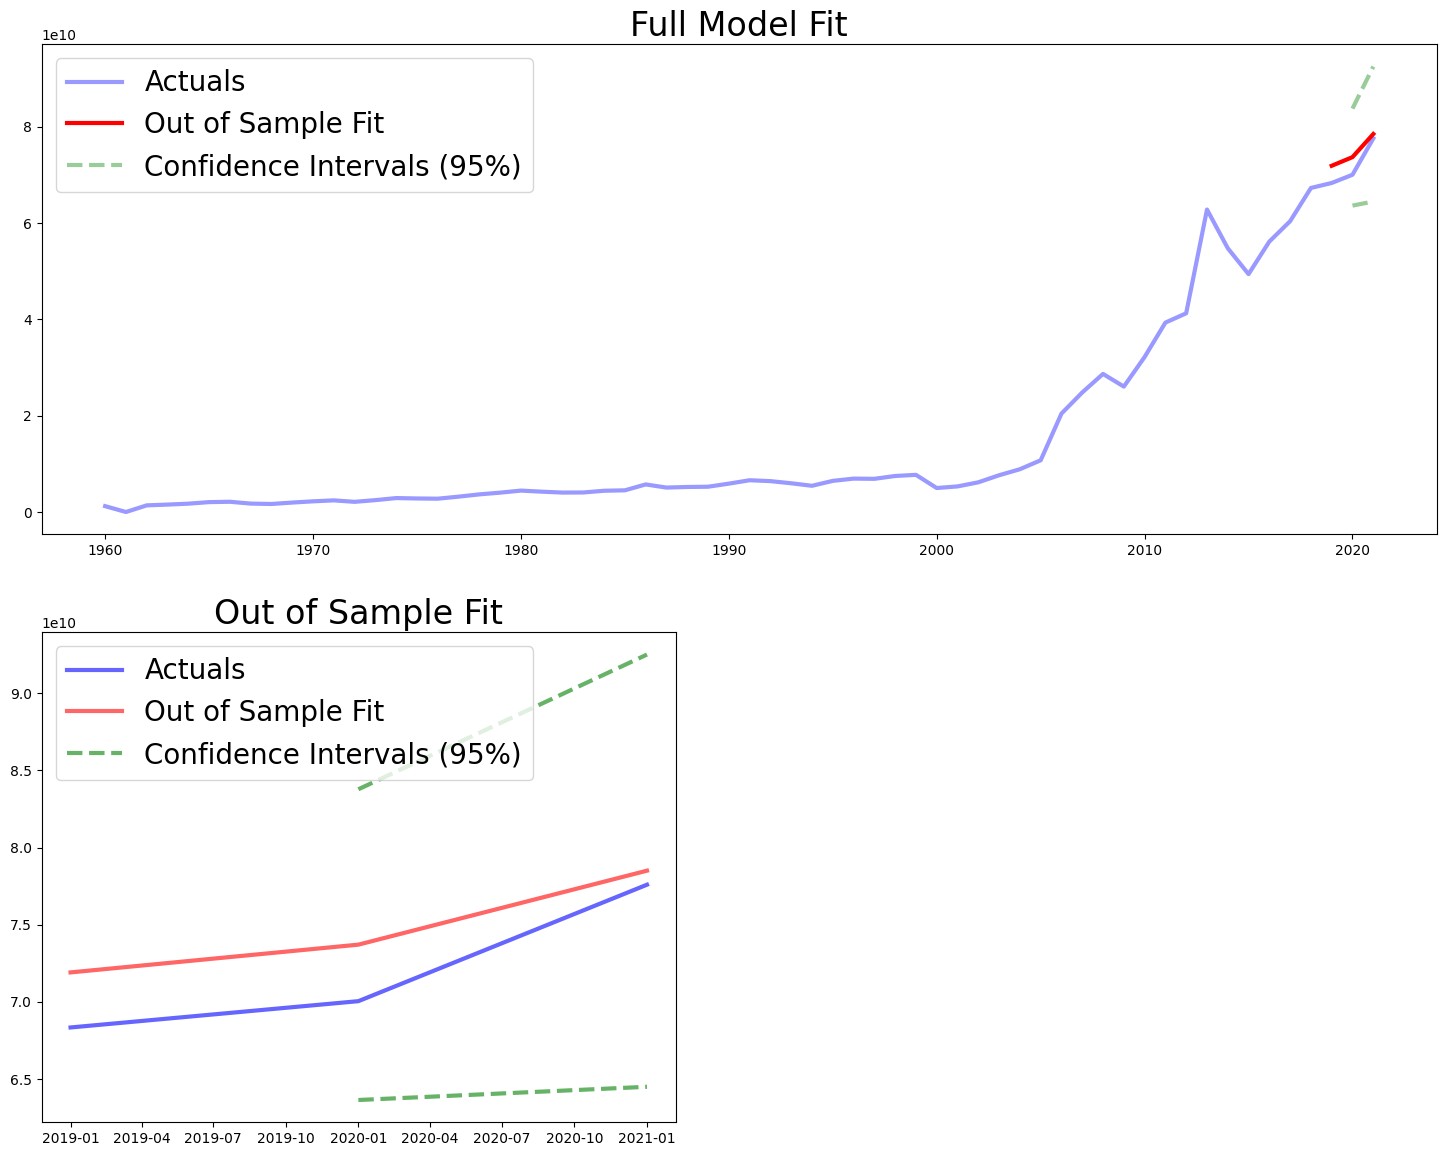

In [58]:
plt.rcParams["figure.figsize"] = 18, 14

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Модель уловила тренд. Предсказания, находятся близко к истинным значениям и в доверительном интервале.

### Интерполяция и сэмплирование.

In [21]:
# Проверка на наличие пропущенных дат
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [22]:
df.isna().sum()

GDP (current US$)    0
dtype: int64

In [23]:
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [24]:
df.isna().sum()

GDP (current US$)    1
dtype: int64

In [25]:
int_data = pd.DataFrame(
    df.interpolate(method='linear'), columns=["GDP (current US$)"]
)

In [26]:
train_df_int = int_data.loc[:"2019-01-01"]
test_df_int = int_data.loc["2019-01-01":]
train_df_int.shape, test_df_int.shape

((60, 1), (3, 1))

In [27]:
test_after_int = stat_test(train_df_int["GDP (current US$)"])

adf:  0.5601921925450479
p-value:  0.9865922097956231
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [28]:
int_data_diff1 = train_df_int.diff().dropna()
test_after_int2 = stat_test(int_data_diff1["GDP (current US$)"])

adf:  -1.6116946029017147
p-value:  0.47708609558960013
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
есть единичные корни, ряд не стационарен


In [29]:
int_data_diff2 = int_data_diff1.diff().dropna()
test_after_int3 = stat_test(int_data_diff2["GDP (current US$)"])

adf:  -2.87360414361609
p-value:  0.04850470474849154
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен


In [30]:
int_data_diff3 = int_data_diff2.diff().dropna()
test_after_int4 = stat_test(int_data_diff3["GDP (current US$)"])

adf:  -5.762483606615097
p-value:  5.630321183424949e-07
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
единичных корней нет, ряд стационарен


Произведено трехкратное дифференцирование, значение d=3.

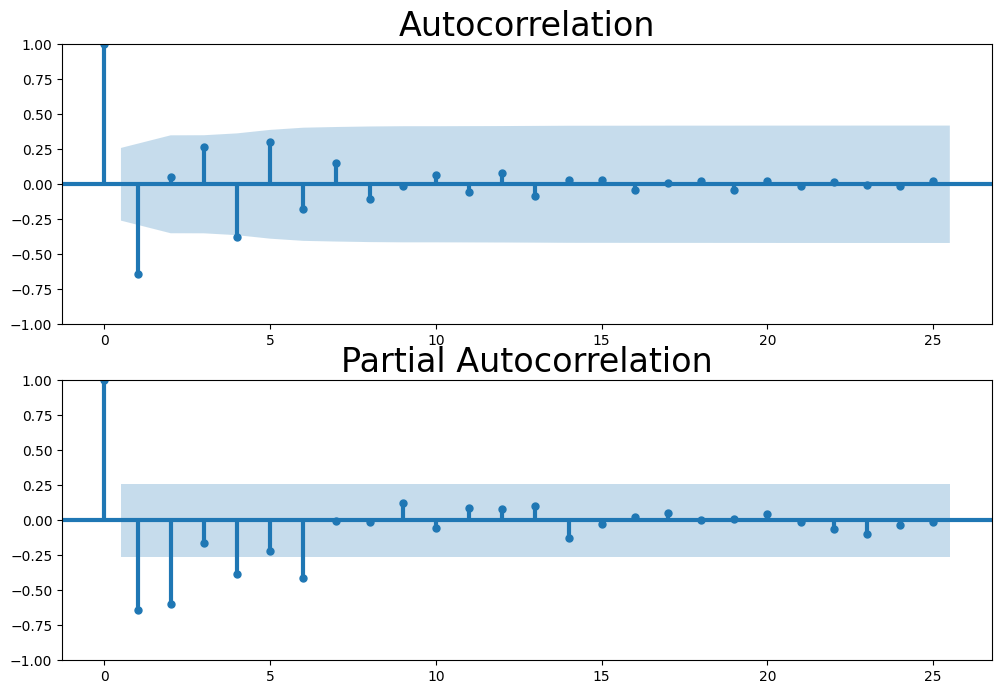

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(int_data_diff3.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(int_data_diff3, lags=25, ax=ax2)

Параметры p = 2 и q = 1 на графиках остались как и до интерполяции. Попробуем подобрать их с помощью pmdarima.

In [32]:
imodel = pm.auto_arima(
    train_df_int,
    d=3,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

imodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2718.203, Time=0.05 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2783.368, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2754.921, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2730.045, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2708.888, Time=0.05 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2730.508, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2710.047, Time=0.07 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2729.201, Time=0.02 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2711.552, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.861 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1350.444
Date:                Sun, 20 Oct 2024   AIC                           2708.888
Time:                        15:11:32   BIC                           2717.061
Sample:                    01-01-1960   HQIC                          2712.064
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7467      0.138     -5.395      0.000      -1.018      -0.475
ar.L2         -0.4523      0.239     -1.894      0.058      -0.920       0.016
ma.L1         -0.9723      0.118     -8.269      0.000      -1.203      -0.742
sigma2      3.402e+19   5.68e-22   5.99e+40      0.000     3.4e+19     3.4e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               143.53
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):             448.22   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Значения, полученные с помощью Pmdarima совпадают со значениями, полученными с помощью графиков. Используем их для построения модели.

In [33]:
arima_model_int = ARIMA(train_df_int["GDP (current US$)"].dropna(), order=(2, 3, 1))
arima_model_int_fit = arima_model_int.fit()
arima_model_int_fit.summary()

c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   60
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1350.444
Date:                Sun, 20 Oct 2024   AIC                           2708.888
Time:                        15:11:32   BIC                           2717.061
Sample:                    01-01-1960   HQIC                          2712.064
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7467      0.138     -5.395      0.000      -1.018      -0.475
ar.L2         -0.4523      0.239     -1.894      0.058      -0.920       0.016
ma.L1         -0.9723      0.118     -8.269      0.000      -1.203      -0.742
sigma2      3.402e+19   5.68e-22   5.99e+40      0.000     3.4e+19     3.4e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               143.53
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):             448.22   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [34]:
pred_df_int = pd.DataFrame(index=int_data.index)

pred_df_int["model_preds"] = arima_model_int_fit.predict(
    start=test_df_int.index[0], end=test_df_int.index[-1]
)


pred_df_int["GDP (current US$)"] = int_data["GDP (current US$)"]

forecast_int = arima_model_int_fit.get_forecast(len(test_df_int.index))
forecast_df_int = forecast_int.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df_int.at[test_df_int.index, "model_preds_lower"] = forecast_df_int["lower GDP (current US$)"]
pred_df_int.at[test_df_int.index, "model_preds_upper"] = forecast_df_int["upper GDP (current US$)"]

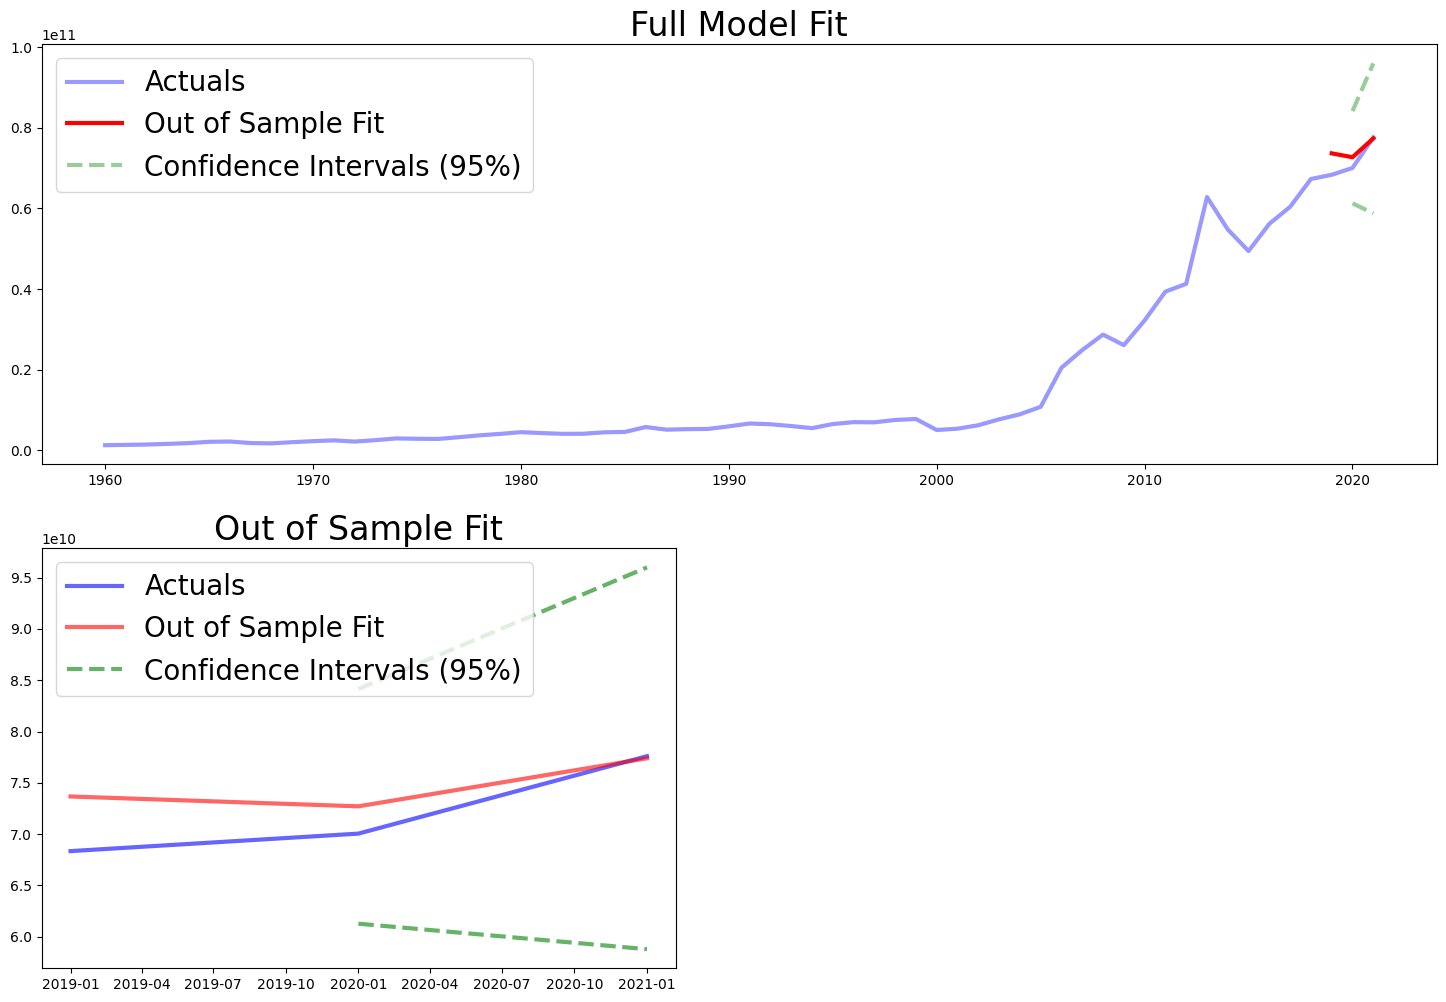

In [35]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df_int["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df_int.loc[test_df_int.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df_int.loc[test_df_int.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

AIC критерий на интерполированных данных стал немного выше, т.е. ухудшился. При этом визуально модель, построенная на интерполированных данных с другими значениями p и q, все также уловила тренд и предсказанные значения находятся в пределах доверительного интервала.

#### Валидация временных рядов

In [36]:
from sklearn.model_selection import TimeSeriesSplit

In [37]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df)
for train_index, test_index in train_test_groups:
    print('Train size:', len(train_index), 'Test size:', len(test_index))

Train size: 41 Test size: 7
Train size: 48 Test size: 7
Train size: 55 Test size: 7


### Модели прогнозирования гетероскедастичности. Валидация временных рядов.

Считаем волатильность.

In [38]:
df["gdp_vol"] = int_data['GDP (current US$)'].pct_change(1).mul(100).abs()
df["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

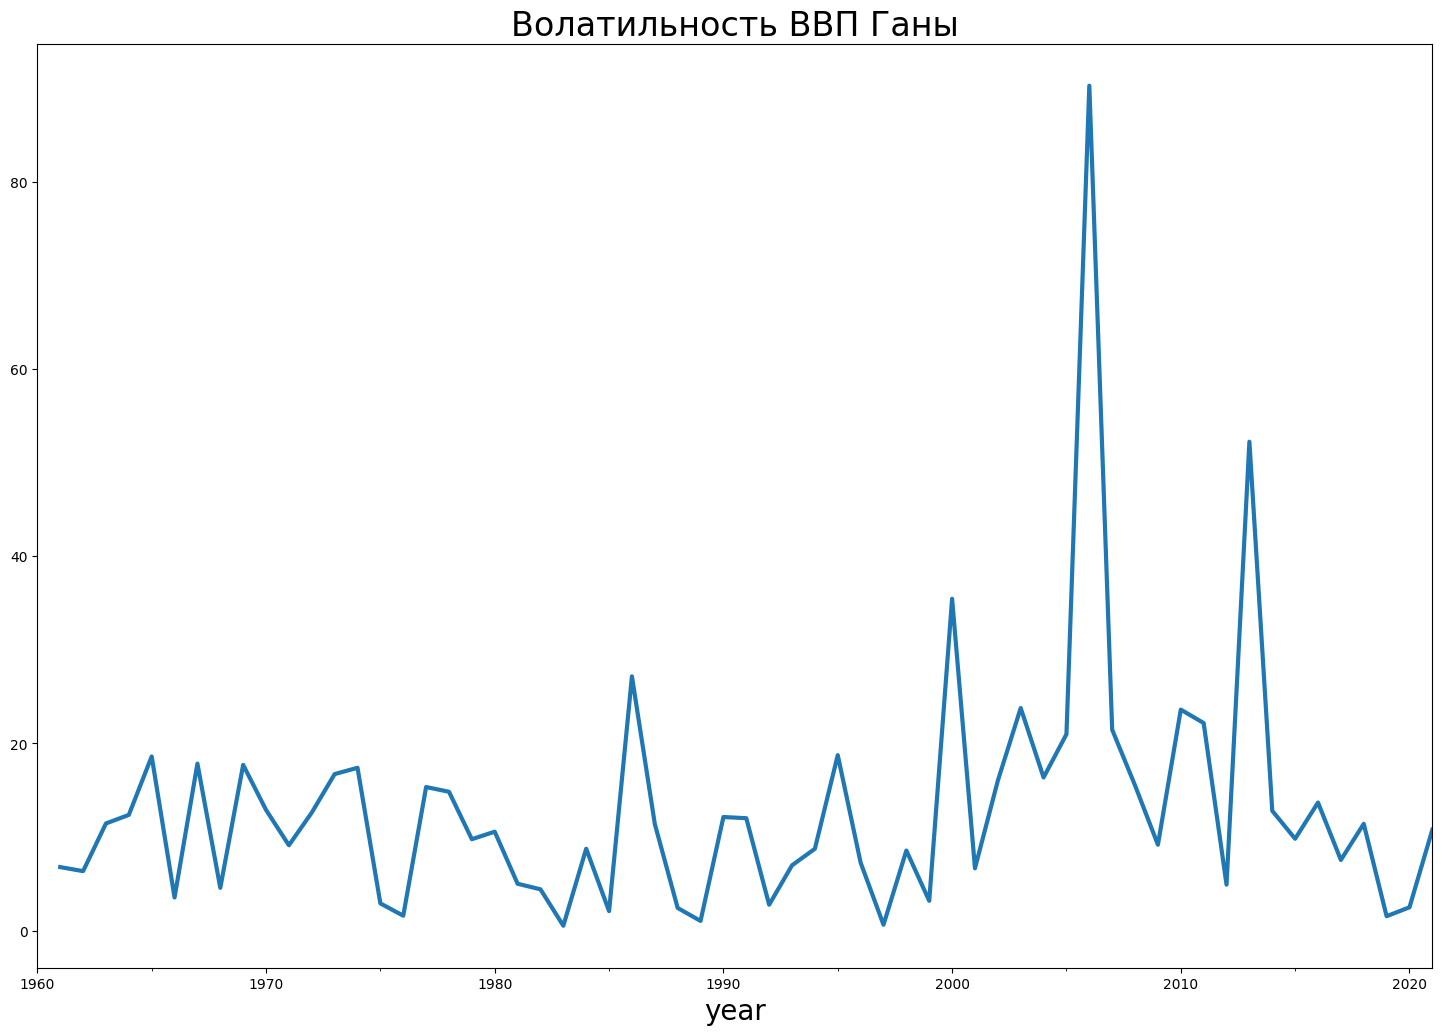

In [39]:
df["gdp_vol"].plot()
plt.title("Волатильность ВВП Ганы")
plt.show()

ВВП Ганы имеет достаточно большую дисперсию волатильности.

In [40]:
train_df_vol = df.loc[:"2019-01-01"]
test_df_vol = df.loc["2019-01-01":]
train_df_vol.shape, test_df_vol.shape

((60, 2), (3, 2))

In [41]:
test_vol = stat_test(train_df_vol["gdp_vol"].loc['1961-01-01':])

adf:  -6.726503409724899
p-value:  3.379140565297867e-09
Critical values:  {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}
единичных корней нет, ряд стационарен


Тест Дики Фуллера показывает, что ряд стационарен. Построим графики авторегрессии и частичной авторегрессии, чтобы выбрать p и q.

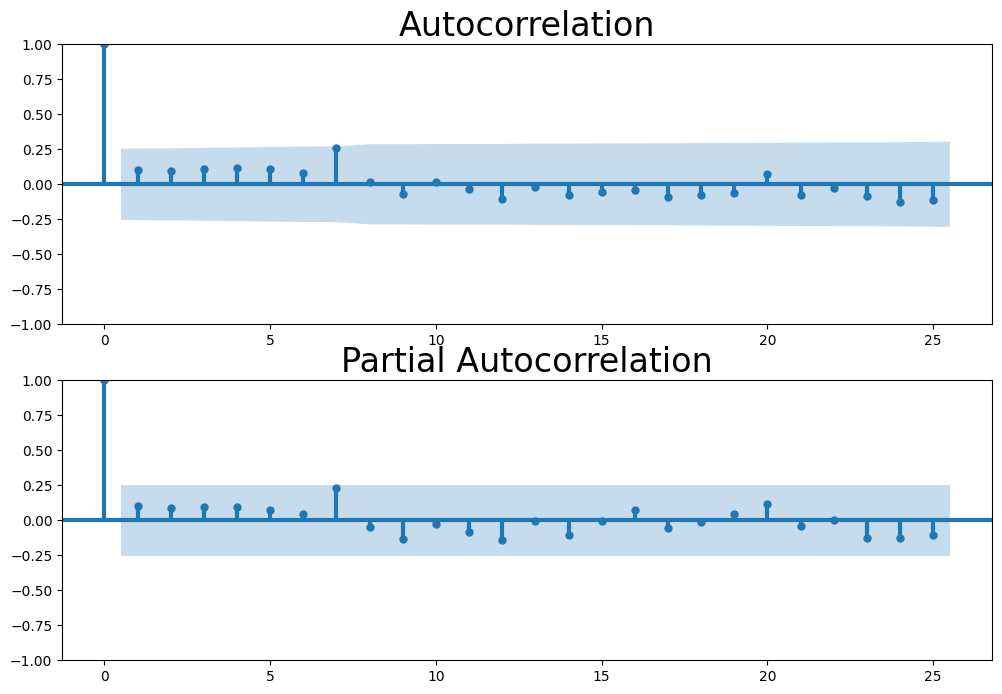

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df_vol['gdp_vol'].loc['1961-01-01':].squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df_vol['gdp_vol'].loc['1961-01-01':], lags=25, ax=ax2)

In [43]:
garch_df = pd.DataFrame(df["gdp_vol"].loc[df.index])

In [44]:
pip install arch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
from arch import arch_model

In [46]:
model_arch = arch_model(garch_df['gdp_vol'].dropna(), p=1, q=1, vol = 'GARCH')
model_arch_results = model_arch.fit(last_obs=test_df_vol.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [47]:
model_arch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Sun, Oct 20 2024   Df Residuals:                       57
Time:                        15:11:39   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [48]:
predictions_df = test_df_vol.copy()
predictions_df["Arch_predictions"] = model_arch_results.forecast().residual_variance.loc[
    test_df_vol.index
]

In [49]:
train, test = df.iloc[:-3,1], df.iloc[-3:,1]
train = train.loc['1961-01-01':]
train.shape, test.shape

((58,), (3,))

In [50]:

X_train, X_test = np.arange(train.shape[0]).reshape(-1, 1), np.arange(test.shape[0]).reshape(-1, 1) 
y_train, y_test = train.values, test.values

In [51]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train, y_train)
predictions_df['linear_predictions'] = lr.predict(X_test)

In [52]:
predictions_df

,GDP (current US$),gdp_vol,Arch_predictions,linear_predictions
year,,,,
2019-01-01,6.833754e+10,1.542746,288.546011,7.314433
2020-01-01,7.004320e+10,2.495937,292.216032,7.530041
2021-01-01,7.759428e+10,10.780603,295.886053,7.745649


In [53]:
import seaborn as sns

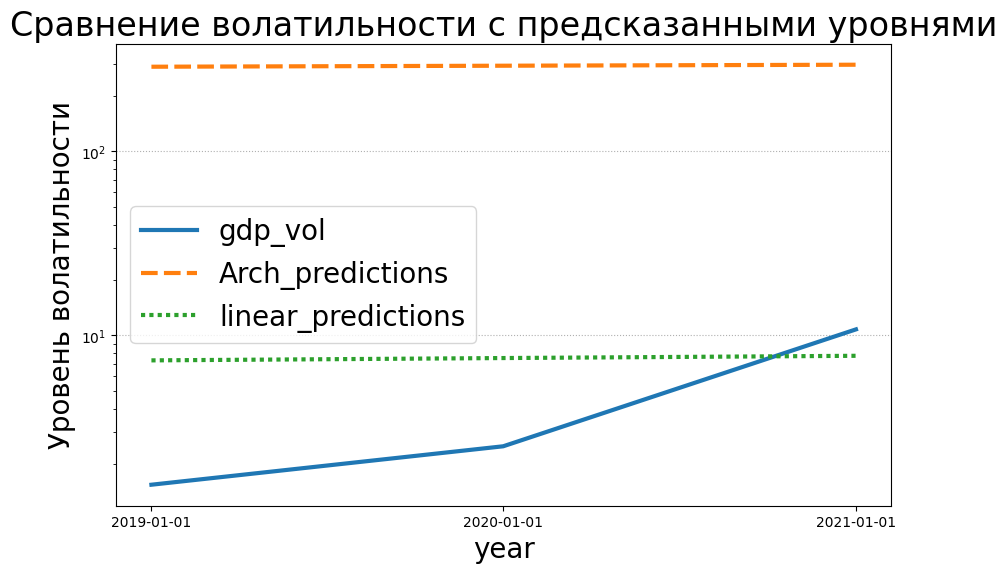

In [54]:
predictions_df_lineplot = predictions_df.drop(['GDP (current US$)'], axis=1)
fig_id = 10

plt.figure(figsize=(10,6))
fig = sns.lineplot(predictions_df_lineplot)

plt.xticks(test.index)
fig.yaxis.grid(linestyle=':')
plt.yscale('log')

plt.title("Сравнение волатильности с предсказанными уровнями")
plt.ylabel("Уровень волатильности")
plt.show();

В данном случае ни одна из моделей ни уловила дисперсию. Возможно это связано с ограниченным количеством данных и отсутствием подобного поведения в обучающей выборке.